In [1]:
import jax

jax.config.update(
    "jax_compilation_cache_dir", "/cluster/scratch/mpundir/jax-cache-notebook"
)
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np

import functools
from jax.typing import ArrayLike
from jax import Array

from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools
from matplotlib.gridspec import GridSpec

In [3]:
import sys

sys.path.append("../fft_helpers/")

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor
from custom_solvers import conjugate_gradient

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf


\begin{align*}
    \underset{\rho}{ \text{maximize}} &:~ f(\rho, \boldsymbol{F}) \\
     \text{s.t} &: ~\mathcal{F}^{-1} \{ \mathcal{F} \{  \mathbb{G} \} :   \mathcal{F} \{ \sigma \} \}  = 0~, \\
                & : ~\int \rho(\boldsymbol{x}) d\Omega / \int d\Omega = \vartheta~,  \\
                & :~ 0 \leq \rho(\boldsymbol{x}) \leq 1 , \forall \boldsymbol{x} \in \Omega  
\end{align*}


The implementation of `Optimality criteria` and `sensitivity filter` has been taken from the work of Chandrasekhar et al [http://arxiv.org/abs/2104.01965](AuTO: A Framework for Automatic differentiation in Topology Optimization)

In [4]:
# %% Filter
# Reference: http://arxiv.org/abs/2104.01965
def compute_filter(rmin):
    H = np.zeros((N * N, N * N))

    for i1 in range(N):
        for j1 in range(N):
            e1 = (i1) * N + j1
            imin = max(i1 - (np.ceil(rmin) - 1), 0.0)
            imax = min(i1 + (np.ceil(rmin)), N)
            for i2 in range(int(imin), int(imax)):
                jmin = max(j1 - (np.ceil(rmin) - 1), 0.0)
                jmax = min(j1 + (np.ceil(rmin)), N)
                for j2 in range(int(jmin), int(jmax)):
                    e2 = i2 * N + j2
                    H[e1, e2] = max(
                        0.0, rmin - np.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)
                    )

    Hs = np.sum(H, 1)
    return H, Hs

In [109]:
#length = 1.0
N = 99

# material parameters
elastic_modulus = {"max": 1.0, "min": 1e-3}  # N/mm2
poisson_modulus = 0.3
penalty = 5.0

vf = 0.3

dx = dy = 1.0
length = dx*N

H, Hs = compute_filter(rmin=1.3)
ft = {"type": 2, "H": H, "Hs": Hs}


μ = elastic_modulus['max'] / (2 * (1 + poisson_modulus))
λ = poisson_modulus * elastic_modulus['max'] / ((1 + poisson_modulus) * (1 - 2 * poisson_modulus))
λ = 2*μ*λ/(λ + 2*μ) # for plane stress
K = λ + 2 * μ / 2
print(μ*K*vf/(2*μ+2*K-(K+2*μ)*vf))

Hmax = μ*K/(K+2*μ)

0.0470219435736677


In [116]:
μ

0.3846153846153846

In [110]:
trial = vf/(Hmax+ μ) + (1-vf)/Hmax

In [111]:
1/trial - Hmax

0.04702194357366771

In [35]:
ndim = 2
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum("ij,xy", i, jnp.ones([N, N]))  # 2nd order Identity tensor

I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)


I4s = (I4 + I4rt) / 2.0
II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

In [36]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

In [37]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="rotated", length=length)

In [38]:
@jax.jit
def param(rho):
    rho = rho.reshape(N, N)
    E = (
        elastic_modulus["min"]
        + (elastic_modulus["max"] - elastic_modulus["min"]) * (rho + 0.01) ** penalty
    )
    return E

In [39]:
# --------------------------#
# Reference: http://arxiv.org/abs/2104.01965
def get_initial_density(vf):
    rho = vf * np.ones((N, N))
    d = np.minimum(N, N) / 3.0
    ctr = 0
    for i in range(N):
        for j in range(N):
            r = np.sqrt((i - N / 2.0 - 0.5) ** 2 + (j - N / 2.0 - 0.5) ** 2)
            if r < d:
                rho[j, i] = vf / 2.0
            ctr += 1
    rho = rho.reshape(-1)
    return rho

In [40]:
# Reference: http://arxiv.org/abs/2104.01965
def apply_sensitivity_filter(ft, x, dc, dv):
    if ft["type"] == 1:
        dc = np.matmul(ft["H"], np.multiply(x, dc) / ft["Hs"] / np.maximum(1e-3, x))
    elif ft["type"] == 2:
        dc = np.matmul(ft["H"], (dc / ft["Hs"]))
        dv = np.matmul(ft["H"], (dv / ft["Hs"]))
    return dc, dv

In [41]:
# Reference: http://arxiv.org/abs/2104.01965
def oc(rho, dc, dv, ft, vf):
    l1 = 0

    l2 = 1e9
    x = rho.copy()
    move = 0.2
    while l2 - l1 > 1e-6:
        lmid = 0.5 * (l2 + l1)
        dr = np.abs(-dc / dv / lmid)

        xnew = np.maximum(
            0,
            np.maximum(x - move, np.minimum(1, np.minimum(x + move, x * np.sqrt(dr)))),
        )
        if ft["type"] == 1:
            rho = xnew
        elif ft["type"] == 2:
            rho = np.matmul(ft["H"], xnew) / ft["Hs"]
        if np.mean(rho) > vf:
            l1 = lmid
        else:
            l2 = lmid

    change = np.max(np.abs(xnew - x))
    return rho, change

In [42]:
@jax.jit
def strain_energy(eps, rho):
    rho = rho.reshape(N, N)
    eps = eps.reshape(ndim, ndim, N, N)
    
    E = (
        elastic_modulus["min"]
        + (elastic_modulus["max"] - elastic_modulus["min"]) * (rho + 0.01) ** penalty
    )
    ν = jnp.ones_like(E) * poisson_modulus

    μ0 = E / (2 * (1 + ν))

    λ0 = ν * E / ((1 + ν) * (1 - 2 * ν))
    λ0 = 2*μ0*λ0/(λ0 + 2*μ0) # for plane stress


    eps_sym = 0.5 * (eps + tensor.trans2(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(eps_sym) ** 2) + jnp.multiply(
        μ0, tensor.trace2(tensor.dot22(eps_sym, eps_sym))
    )
    return energy.sum()


sigma = jax.jit(jax.jacrev(strain_energy, argnums=0))

In [43]:
# functions for the projection 'G', and the product 'G : K : eps'
@jax.jit
def G(A2):
    return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)


@jax.jit
def G_K_deps(depsm, additionals):
    depsm = depsm.reshape(ndim, ndim, N, N)
    return G(sigma(depsm, additionals))

In [44]:
@jax.jit
def scan_conjugate_gradient(state, n):
    x, b, F, Fn, additional, r, p, rsold, iiter, cg_tol = state
    x, b, additional, r, p, rsold = jax.device_put((x, b, additional, r, p, rsold))
      
    error = jnp.sqrt(rsold) 
    jax.debug.print('CG residual = {}', error)
    
    def true_fun(state):
        x, b, F, Fn, additional, r, p, rsold, iiter, cg_tol =  state

        Ap = G_K_deps(p, additional) 
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r) 
        p = r + (rsnew/rsold)*p
        rsold = rsnew
        iiter = iiter + 1
        return (x, b, F, Fn, additional, r, p, rsold, iiter, cg_tol)

    def false_fun(state):
        return state

    return jax.lax.cond(error > cg_tol, true_fun, false_fun, state), n

@jax.jit
def scan_newton_raphson(state, n):
    #jax.debug.print('NR loop')
    dF, b, F, Fn, additional, r, p, rsold, iiter, cg_tol = state



    error = jnp.linalg.norm(dF)/Fn
    
    #jax.debug.print('NR residual={}', error)

    def true_fun(state):
        dF, b, F, Fn, additional, r, p, rsold, iiter, cg_tol = state

        x = jnp.zeros_like(b)
        r = b - G_K_deps(x, additional)
        p = r
        rsold = jnp.vdot(r, r) 

        state = (x, b, F, Fn, additional, r, p, rsold, iiter, cg_tol)
        
        state, xs = jax.lax.scan(scan_conjugate_gradient, 
                               init=state, 
                               xs=jnp.arange(0, 20))
        
        dF, b, F, Fn, additional, r, p, rsold, iiter, cg_tol = state

        dF     = dF.reshape(ndim,ndim,N,N)
        F      = jax.lax.add(F, dF)         # update DOFs (array -> tensor.grid)
        b      = -G_K_deps(F, additional)        # compute residual

        return (dF.reshape(-1), b, F, Fn, additional, r, p, rsold, iiter, cg_tol)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-8, true_fun, false_fun, state), n

In [ ]:
@jax.jit
def local_constitutive_update(macro_strain, rho):
    eps = jnp.zeros([ndim, ndim, N, N])

    deps = jnp.zeros([ndim, ndim, N, N])
    deps = deps.at[0, 0].set(macro_strain[0])
    deps = deps.at[1, 1].set(macro_strain[1])
    deps = deps.at[0, 1].set(macro_strain[2] / 2.0)
    deps = deps.at[1, 0].set(macro_strain[2] / 2.0)

    # initial residual: distribute "DE" over grid using "K4"
    b = -G_K_deps(deps, rho)
    eps = jax.lax.add(eps, deps)
    En = jnp.linalg.norm(eps)

    # passing parameters for conjugate gradient
    deps     = deps.reshape(-1)
    r        = jnp.zeros_like(b)
    p        = jnp.zeros_like(b) 
    rsold    = 0.
    iiter    = 0.
    cg_tol   = 1e-8
    
    state    = (deps, b, eps, En, rho,  r, p, rsold, iiter, cg_tol)
    
    
    #state = (deps, b, eps, En, rho)
    state = jax.device_put(state)

    final_state, xs = jax.lax.scan(
        scan_newton_raphson, init=state, xs=jnp.arange(0, 20)
    )

    sig = sigma(final_state[2], rho)

    # get the macro stress
    macro_sigma = jnp.array([jnp.sum(sig.at[0, 0].get()*dx*dy), 
                             jnp.sum(sig.at[1, 1].get()*dx*dy), 
                             0.5*(jnp.sum(sig.at[1, 0].get()*dx*dy) + jnp.sum(sig.at[0, 1].get()*dx*dy))])
    macro_sigma = macro_sigma/length**2

    return macro_sigma


tangent_operator = jax.jit(jax.jacfwd(
    local_constitutive_update, argnums=0, has_aux=False
))

In [46]:
@jax.jit
def compute_objective(rho):
    rho = rho.reshape(N, N)

    macro_strain = jnp.array([1.0, 1.0, 1.])

    Cmacro = tangent_operator(macro_strain, rho)
    shear_modulus = Cmacro.at[2, 2].get()
    bulk_modulus = (Cmacro.at[0, 0].get() + Cmacro.at[1, 1].get() + Cmacro.at[0, 1].get() + Cmacro.at[1, 0].get())/4 
    poisson = (Cmacro.at[1, 0].get() + Cmacro.at[0, 1].get())/(Cmacro.at[0, 0].get() + Cmacro.at[1, 1].get())
    J = -shear_modulus
    #J = -poisson
    #J = -bulk_modulus
    '''eps = jnp.zeros([ndim, ndim, N, N])

    deps = jnp.zeros([ndim, ndim, N, N])
    deps = deps.at[0, 0].set(macro_strain[0])
    deps = deps.at[1, 1].set(macro_strain[1])
    deps = deps.at[0, 1].set(macro_strain[2] / 2.0)
    deps = deps.at[1, 0].set(macro_strain[2] / 2.0)

    # initial residual: distribute "DE" over grid using "K4"
    b = -G_K_deps(deps, rho)
    eps = jax.lax.add(eps, deps)
    En = jnp.linalg.norm(eps)

    # passing parameters for conjugate gradient
    deps     = deps.reshape(-1)
    #deps2    = jnp.zeros([ndim,ndim,N,N])
    r        = jnp.zeros_like(b)
    p        = jnp.zeros_like(b) 
    rsold    = 0.
    iiter    = 0.
    cg_tol   = 1e-10
    
    state    = (deps, b, eps, En, rho,  r, p, rsold, iiter, cg_tol)
    
    
    #state = (deps, b, eps, En, rho)
    state = jax.device_put(state)

    final_state, xs = jax.lax.scan(
        scan_newton_raphson, init=state, xs=jnp.arange(0, 20)
    )

    # return macro_sigma
    total_energy = 2*strain_energy(final_state[2], rho) #* length * length

    J = -(total_energy)/(N*N)'''
    jax.debug.print('J={}', J)

    return J, J


objective_handle = jax.jit(jax.jacrev(compute_objective, has_aux=True))

In [47]:
from jax import random

key = random.key(2)

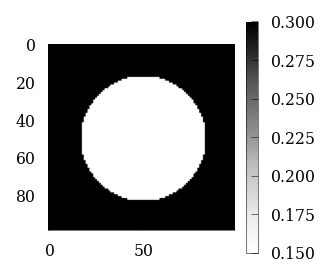

In [48]:
rho = get_initial_density(vf=vf)
#rho=random.uniform(key, shape=(N, N))
plt.figure(figsize=(2,2))
plt.imshow(rho.reshape(N, N), cmap='Greys')
plt.colorbar()

In [49]:
compute_objective(rho)

CG residual = 0.19215160248560498
CG residual = 0.03345801064545514
CG residual = 0.022725244309689748
CG residual = 0.0021253379410087654
CG residual = 0.001529706416414285
CG residual = 0.0005935165225546164
CG residual = 0.0002536036955032072
CG residual = 0.0001960918878238921
CG residual = 6.989287153370691e-05
CG residual = 3.760377319774217e-05
CG residual = 1.7913117236356724e-05
CG residual = 4.357326472072343e-06
CG residual = 3.587074687253273e-06
CG residual = 1.0326111687990387e-06
CG residual = 5.653929164246273e-07
CG residual = 3.9625023224069544e-07
CG residual = 1.208386419206797e-07
CG residual = 7.332997495460921e-08
CG residual = 2.9781698163273268e-08
CG residual = 1.0437096819147349e-08
CG residual = 7.355661187859818e-09
CG residual = 7.355661187859818e-09
CG residual = 7.355661187859818e-09
CG residual = 7.355661187859818e-09
CG residual = 7.355661187859818e-09
CG residual = 7.355661187859818e-09
CG residual = 7.355661187859818e-09
CG residual = 7.3556611878598

(Array(-0.00087879, dtype=float64), Array(-0.00087879, dtype=float64))

In [50]:
def optimize(maxIter=100):
    rho = jnp.array(get_initial_density(vf))
    change, loop = 10.0, 0

    objective_values = []
    
    while change > 0.01 and loop < maxIter:
        loop += 1
        dc, c = objective_handle(rho)

        dv = jnp.ones((N * N))
        dc, dv = apply_sensitivity_filter(ft, rho, dc, dv)

        rho, change = oc(rho, dc, dv, ft, vf)
        rho = jnp.array(rho)
        status = "iter {:d} ;  obj {:.2F} ; vol {:.2F}".format(loop, c, jnp.mean(rho))
        objective_values.append(c)
        if loop % 20 == 0:
            plt.figure(figsize=(2, 2))
            plt.imshow(-rho.reshape((N, N)), cmap="gray")
            plt.title(status)
            plt.show()

        print(status, "change {:.2F}".format(change))
    plt.imshow(-rho.reshape((N, N)), cmap="gray")

    return rho, objective_values

J=-0.0008787942863382298
iter 1 ;  obj -0.00 ; vol 0.22 change 0.17
J=-0.0011264292428687427
iter 2 ;  obj -0.00 ; vol 0.23 change 0.20
J=-0.004658982855837879
iter 3 ;  obj -0.00 ; vol 0.28 change 0.20
J=-0.018540684887511497
iter 4 ;  obj -0.02 ; vol 0.30 change 0.20
J=-0.05008469804326539
iter 5 ;  obj -0.05 ; vol 0.30 change 0.20
J=-0.06264786596329028
iter 6 ;  obj -0.06 ; vol 0.30 change 0.20
J=-0.06676397728363354
iter 7 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.06930372871575895
iter 8 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.07066291773856068
iter 9 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.07173360640108709
iter 10 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.07259355408918161
iter 11 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.07303912658189629
iter 12 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.0734045811445772
iter 13 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.07375986215516153
iter 14 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.07410438109466494
iter 15 ;  obj -0.07 ; vol 0.30 change 0.20

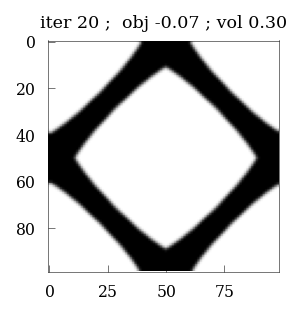

iter 20 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.0748411880828251
iter 21 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.07495386007683479
iter 22 ;  obj -0.07 ; vol 0.30 change 0.20
J=-0.07516157320342541
iter 23 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07517218876755548
iter 24 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07526691061178795
iter 25 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07514858970577003
iter 26 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.0752804842692488
iter 27 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.07522608497798886
iter 28 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.07517537991604127
iter 29 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.07512172231358034
iter 30 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07520869691190356
iter 31 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.07513338635393747
iter 32 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07521255448738662
iter 33 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.07513287188385283
iter 34 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.075209034093730

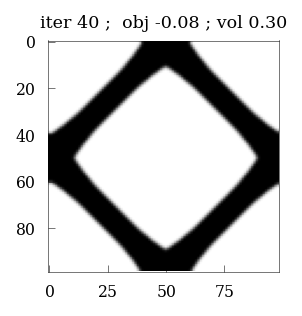

iter 40 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07518533491640893
iter 41 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.0751017526410719
iter 42 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07517606349066527
iter 43 ;  obj -0.08 ; vol 0.30 change 0.19
J=-0.07523601320525647
iter 44 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.07514937030673974
iter 45 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07522147202405528
iter 46 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.07513685759584564
iter 47 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.0752102722182237
iter 48 ;  obj -0.08 ; vol 0.30 change 0.18
J=-0.07512612248099407
iter 49 ;  obj -0.08 ; vol 0.30 change 0.20
J=-0.07519981460437301
iter 50 ;  obj -0.08 ; vol 0.30 change 0.18


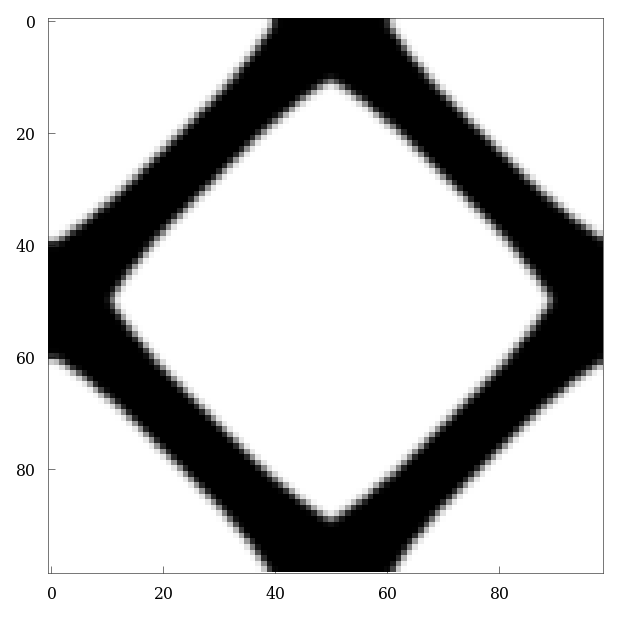

In [51]:
rho, objective_values = optimize(50)

In [93]:
@jax.jit
def compute_local_stresses(macro_strain, rho):
    eps = jnp.zeros([ndim, ndim, N, N])

    deps = jnp.zeros([ndim, ndim, N, N])
    deps = deps.at[0, 0].set(macro_strain[0])
    deps = deps.at[1, 1].set(macro_strain[1])
    deps = deps.at[0, 1].set(macro_strain[2] / 2.0)
    deps = deps.at[1, 0].set(macro_strain[2] / 2.0)

    # initial residual: distribute "DE" over grid using "K4"
    b = -G_K_deps(deps, rho)
    eps = jax.lax.add(eps, deps)
    En = jnp.linalg.norm(eps)

    # passing parameters for conjugate gradient
    deps     = deps.reshape(-1)
    r        = jnp.zeros_like(b)
    p        = jnp.zeros_like(b) 
    rsold    = 0.
    iiter    = 0.
    cg_tol   = 1e-8
    
    state    = (deps, b, eps, En, rho,  r, p, rsold, iiter, cg_tol)
    
    
    #state = (deps, b, eps, En, rho)
    state = jax.device_put(state)

    final_state, xs = jax.lax.scan(
        scan_newton_raphson, init=state, xs=jnp.arange(0, 20)
    )

    sig = sigma(final_state[2], rho)
    return sig

In [94]:
macro_strain = jnp.array([0.0, 0.0, 1.])
stresses = compute_local_stresses(macro_strain, rho)

CG residual = 17.3171631235316
CG residual = 3.3523559935266927
CG residual = 1.1616458628170108
CG residual = 0.7071048239993468
CG residual = 0.4102551775383743
CG residual = 0.2815996234262036
CG residual = 0.2356726717604784
CG residual = 0.20847552404537817
CG residual = 0.14748031924978694
CG residual = 0.13790977301764834
CG residual = 0.09555820905314172
CG residual = 0.08580380458913597
CG residual = 0.07853635788754036
CG residual = 0.06432296058473638
CG residual = 0.05913485120473688
CG residual = 0.040752123349128845
CG residual = 0.03699377371342441
CG residual = 0.02670692886935146
CG residual = 0.027017180958343504
CG residual = 0.02443745369940184
CG residual = 0.023329746504566765
CG residual = 0.016573304106826843
CG residual = 0.016184892287336883
CG residual = 0.016088822061484966
CG residual = 0.017997440874972737
CG residual = 0.017282984372111804
CG residual = 0.01905502625590263
CG residual = 0.016459220779385345
CG residual = 0.016508583930901048
CG residual =

In [145]:
import matplotlib.gridspec as gridspec
from matplotlib import ticker


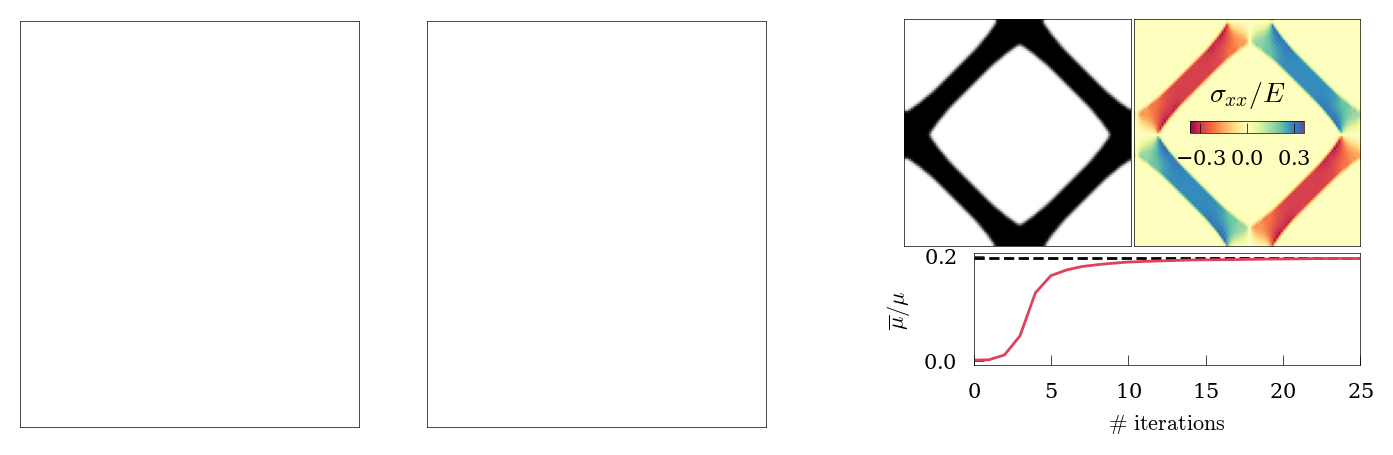

In [197]:
fig = plt.figure(
    figsize=set_size(width="two-column", fraction=0.975, height_ratio=0.3),
    constrained_layout=False,
    dpi=200,
)
gs1 = gridspec.GridSpec(1, 2, figure=fig,  left=0.01, right=0.55, top=0.98, bottom=0.00)
gs2.update(wspace=0.1) # set the spacing between axes. 

ax = fig.add_subplot(gs1[:, 0])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax = fig.add_subplot(gs1[:, 1])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

gs2 = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 0.5], left=0.65, right=0.98, top=0.99)
gs2.update(hspace=0.1, wspace=0.01) # set the spacing between axes. 


ax = fig.add_subplot(gs2[0, 0])
ax.imshow(rho.reshape((N, N)), cmap="Greys")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


ax = fig.add_subplot(gs2[0, 1])
cs = ax.imshow(stresses.at[0, 0].get(), cmap="Spectral")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
axins1 = ax.inset_axes([0.25, 0.5, 0.5, 0.05])

cbar = fig.colorbar(cs, cax=axins1, pad=0.05, 
                      fraction=0.025, shrink=.5, orientation="horizontal")
tick_locator = ticker.MaxNLocator(nbins=2)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('$\sigma_{xx}/E$', fontsize=10, labelpad=-32, y=0.85)
cbar.ax.yaxis.set_offset_position('right')  


gs3 = gridspec.GridSpec(1, 1, figure=fig, left=0.7, right=0.98, top=0.42,  bottom=0.15)
gs3.update(hspace=0.1, wspace=0.01) # set the spacing between axes. 
ax = fig.add_subplot(gs3[:, :])
ax.plot(-np.asarray(objective_values)/μ, color='#de425b')
ax.axhline(y=np.max(-np.asarray(objective_values)/μ), color='k', ls='dashed', zorder=-1)
ax.set_xlabel(r'$\mathrm{\#~iterations}$')
ax.set_ylabel(r'$\overline{\mu}/\mu$')
ax.set_xlim(left=0, right=25)

plt.savefig('../notebooks/figs/paper_to_shear_modulus.svg')
plt.show()

In [113]:
μ

0.3846153846153846

In [79]:
0.5 0.132
0.3 0.075

SyntaxError: invalid syntax (1803103762.py, line 1)